# `Re-quantification workflow`

This workflow consists of 3 steps. The purpose is missing value imputation caused by the preprocessing algorithms.

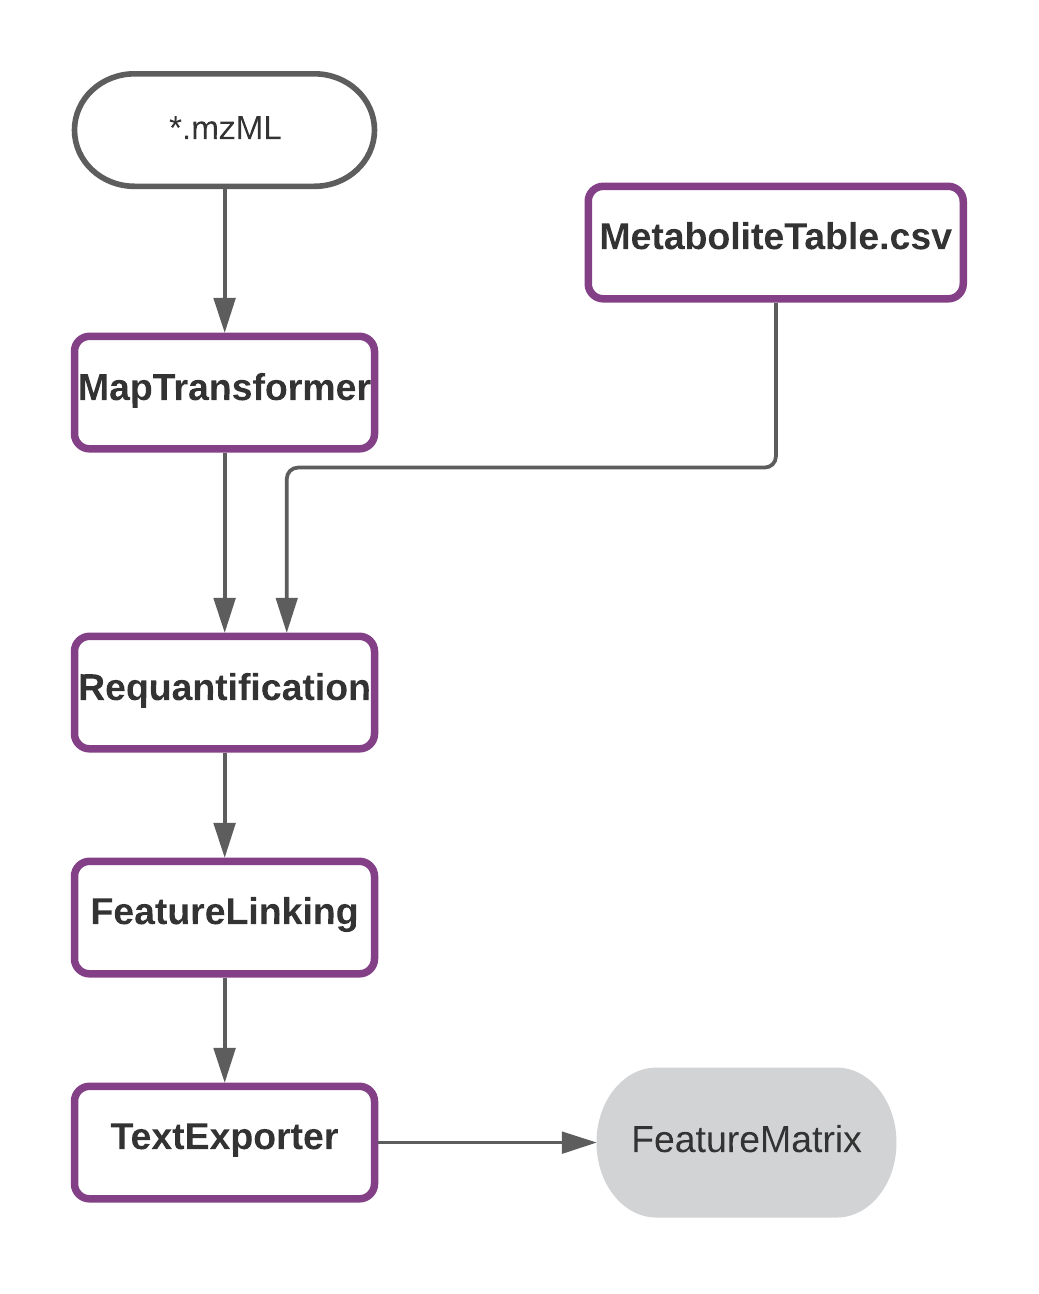

#### `1) Create a library (MetaboliteIdentification table)` 

The first step is to create a library of compounds derived from the features generated from all files in the pre-processing steps. 


Import libraries

In [2]:
import os
import glob
import sys
import pandas as pd
sys.path.insert(0, '/Users/eeko/openms-develop/openms_build/pyOpenMS')
from pyopenms import *

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


In [3]:
#Import the consensus tsv table and keep only the columns: RT, mz and charge
DF_features = pd.read_csv("results/features/FeatureMatrix.tsv", sep="\t")
DF_features = DF_features[['RT','mz', "charge"]]

#convert the mz and RT columns to floats and charge to integer for calculations
DF_features["charge"] = pd.to_numeric(DF_features["charge"], downcast="integer")
DF_features["mz"] = pd.to_numeric(DF_features["mz"], downcast="float")
DF_features["RT"] = pd.to_numeric(DF_features["RT"], downcast="float")

#Add a columns named "Mass" and calculate the neutral masses from the charge and mz:
DF_features["Mass"]= 0.0
for ind in DF_features.index:
    if DF_features["charge"][ind] == 0:
        DF_features.loc[ind, "Mass"]= DF_features.loc[ind,"mz"]
    if DF_features["charge"][ind] == 1:
        DF_features.loc[ind, "Mass"]= DF_features.loc[ind,"mz"]- 1.007825
    if DF_features["charge"][ind] == 2:
        DF_features.loc[ind, "Mass"]= (DF_features.loc[ind,"mz"]*2)- 2.015650
    if DF_features["charge"][ind] == 3:
        DF_features.loc[ind, "Mass"]= (DF_features.loc[ind,"mz"]*3)- 3.023475

#Rename columns to the required ones and add positive or negative sign for charge
DF_features= DF_features.rename(columns={"RT": "RetentionTime", "charge":"Charge"})
DF_features["Charge"]= DF_features["Charge"].astype(str)
for ind in DF_features.index:
    if DF_features["Charge"][ind] == "1":
        DF_features.loc[ind, "Charge"]= "+" + DF_features.loc[ind,"Charge"]
    if DF_features["Charge"][ind] == "2":
        DF_features.loc[ind, "Charge"]= "+" + DF_features.loc[ind,"Charge"]
    if DF_features["Charge"][ind] == "3":
        DF_features.loc[ind, "Charge"]= "+" + DF_features.loc[ind,"Charge"]
#drop the mz column
DF_features= DF_features.drop(columns= "mz")

#add the rest of the columns required for the MetaboliteIdentificationTable and fill with zeros or blanks, except the "Compound Name"
#which, since they are all unknown, can be filled with feature_#
DF_features['CompoundName'] = np.arange(len(DF_features))
DF_features['CompoundName'] = "feature_" + DF_features['CompoundName'].astype(str)
DF_features["SumFormula"] = " "
DF_features["RetentionTimeRange"]= "0"
DF_features["IsoDistribution"]= "0"
DF_features= DF_features[["CompoundName","SumFormula", "Mass","Charge","RetentionTime","RetentionTimeRange", "IsoDistribution"]]
DF_features.to_csv("resources/MetaboliteIdentification.tsv", sep="\t", index= None)
DF_features

,CompoundName,SumFormula,Mass,Charge,RetentionTime,RetentionTimeRange,IsoDistribution
0,feature_0,,227.187961,+1,473.883301,0,0
1,feature_1,,387.255725,+1,637.148010,0,0
2,feature_2,,184.084231,+1,78.825287,0,0
3,feature_3,,194.104983,+1,100.224037,0,0
4,feature_4,,375.255664,+1,634.974243,0,0
...,...,...,...,...,...,...,...
9100,feature_9100,,505.267016,+1,506.687958,0,0
9101,feature_9101,,637.822741,+1,353.056854,0,0
9102,feature_9102,,1534.703954,+2,331.765289,0,0
9103,feature_9103,,1690.831518,+2,343.178772,0,0


#### `2) MapAlignmentTransformer`
This algorithm is used to perform a linear retention time alignment, in order to correct for chromatographic shifts in retention time. Use the trafo XML files from the feature alignment and align the raw spectra.

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/classOpenMS_1_1MapAlignmentTransformer.html

In [4]:
path= "results/interim/Requant"
isExist= os.path.exists(path)
if not isExist:
    os.mkdir(path)

input_mzml_files = sorted(glob.glob('results/interim/PCpeak_*.mzML'))
input_trafo = sorted(glob.glob('results/interim/preprocess/*.trafoXML'))

for filename in input_mzml_files:
    exp= MSExperiment()
    MzMLFile().load(filename, exp)
    exp.sortSpectra(True)
    transformer = MapAlignmentTransformer()

    for trafo_XML in input_trafo:
        trafo=TransformationDescription()
        TransformationXMLFile().load(trafo_XML, trafo, True)
        if os.path.basename(trafo_XML)[11:-9] == os.path.basename(filename)[7:-5]:
            transformer.transformRetentionTimes(exp, trafo, True)
            mzml_file = os.path.join(path, 'MapAligned_' + os.path.basename(exp.getLoadedFilePath())[7:-5] +".mzML")
            MzMLFile().store(mzml_file, exp)

#### `2) FeatureFinderMetaboIdent`
This algorithm detects and extracts MS1 data that match the feature list in the metabolite identification table.

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/UTILS_FeatureFinderMetaboIdent.html

In [5]:
import csv
# read tsv file and create list of FeatureFinderMetaboIdentCompound
def metaboTableFromFile(path_to_library_file):
    metaboTable = []
    with open(path_to_library_file, 'r') as tsv_file:
        tsv_reader = csv.reader(tsv_file, delimiter="\t")
        next(tsv_reader) # skip header
        for row in tsv_reader:
            metaboTable.append(FeatureFinderMetaboIdentCompound(
                row[0], # name
                row[1], # sum formula
                float(row[2]), # mass
                [int(charge) for charge in row[3].split(',')], # charges
                [float(rt) for rt in row[4].split(',')], # RTs
                [float(rt_range) for rt_range in row[5].split(',')], # RT ranges
                [float(iso_distrib) for iso_distrib in row[6].split(',')] # isotope distributions
            ))
    return metaboTable

In [8]:
input_mzml_files=sorted(glob.glob("results/interim/Requant/*.mzML"))
# load ms data from mzML file into MSExperiment
for mzml_file in input_mzml_files:
    spectra = MSExperiment()
    MzMLFile().load(mzml_file, spectra)

    # create FeatureFinderAlgorithmMetaboIdent and assign ms data
    ff = FeatureFinderAlgorithmMetaboIdent()
    ff.setMSData(spectra)

    # read library generate a metabo table with compounds
    metabo_table = metaboTableFromFile('resources/MetaboliteIdentification.tsv')

    params = ff.getParameters()
    params[b'extract:mz_window'] = 5.0 
    params[b'detect:peak_width'] = 20.0  #adjust for wide peaks
    ff.setParameters(params)
    # FeatureMap to store results
    fm = FeatureMap()
    # run the FeatureFinderMetaboIdent with the metabo_table and store results in fm
    ff.run(metabo_table, fm, String(mzml_file))

    # save FeatureMap to file
    ff_file = os.path.join(path, 'FFMI_' + os.path.basename(mzml_file)[11:-5] +".featureXML")
    FeatureXMLFile().store(ff_file, fm)

<RT window size calculated as 240 seconds.> occurred 2 times
Extracting chromatograms...
<RT window size calculated as 80 seconds.> occurred 2 times
Detecting chromatographic peaks...
Found 13688 feature candidates in total.
6610 features left after selection of best candidates.
5958 features left after resolving overlaps (involving 1259 features in 601 groups).
Model fitting: 2705 successes, 3253 failures
Imputing model failures with a linear model based on log(rawIntensities). Slope: 0.871508, Intercept: 1.92722
RT window size calculated as 240 seconds.
RT window size calculated as 80 seconds.
Extracting chromatograms...
Detecting chromatographic peaks...
Found 9735 feature candidates in total.
4592 features left after selection of best candidates.
4050 features left after resolving overlaps (involving 1020 features in 476 groups).
Model fitting: 1890 successes, 2160 failures
Imputing model failures with a linear model based on log(rawIntensities). Slope: 0.893889, Intercept: 1.56372

Display the features as a dataframe:

In [12]:
input_feature_files = sorted(glob.glob('results/interim/Requant/FFMI_*.featureXML'))

for filename in input_feature_files:
    fmap = FeatureMap()
    FeatureXMLFile().load(filename, fmap)
    DF= fmap.get_df()
    feature_csv= os.path.join("results", "", "Requant", "", 'FFMI_' +  os.path.basename(fmap.getMetaValue('spectra_data')[0].decode())[11:-5] +".csv")
    DF.to_csv(feature_csv) #it is not necessary to save those files, unless you would like to compare the number of features before and after requantification like I do below
print(os.path.basename(filename))
display(DF)

FFMI_20211009_UMETAB222_POS_33_FPY12_Plate-13_NBC_01134_rep3.featureXML


,peptide_sequence,peptide_score,ID_filename,ID_native_id,charge,RT,mz,RTstart,RTend,MZstart,MZend,quality,intensity
feature_id,,,,,,,,,,,,,
922721197336210104,None,NaN,None,None,1,472.035931,228.195237,461.128510,487.262421,228.194667,228.195807,4.346976,9.809597e+06
3749305416046817057,None,NaN,None,None,1,278.264785,399.234437,271.616974,285.126984,399.233439,399.235435,1.933313,3.356388e+05
17279903300824344528,None,NaN,None,None,1,265.615375,458.260560,261.011505,270.418365,458.259414,458.261706,1.688067,5.222385e+04
10608986683863263200,None,NaN,None,None,1,341.762028,197.106782,334.632385,348.873108,197.106289,197.107275,-4.498508,6.163218e+04
9388485544539895794,None,NaN,None,None,1,368.214485,516.245484,355.858765,374.558380,516.244194,516.246775,3.397196,2.415368e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7667443987467879461,None,NaN,None,None,1,338.916323,360.191682,330.329987,344.600098,360.190781,360.192582,3.773674,3.419712e+06
8435625749200995548,None,NaN,None,None,1,296.530783,588.299500,286.422180,309.704895,588.298030,588.300971,4.326899,3.935535e+06
13558774529073989722,None,NaN,None,None,1,365.567498,489.197785,346.009888,379.533356,489.196562,489.199008,4.287596,3.776871e+05


#### `3) FeatureGroupingAlgorithmKD `

Feature linker aggregates the feature information (from single files) into a ConsensusFeature, linking features from different files together, which have a smiliar m/z and rt (no MS2 data).

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/release/latest/html/TOPP_FeatureLinkerUnlabeledKD.html

In [13]:
feature_grouper = FeatureGroupingAlgorithmKD()

consensus_map = ConsensusMap()
file_descriptions = consensus_map.getColumnHeaders()

input_feature_files = sorted(glob.glob('results/interim/Requant/*.featureXML'))

feature_maps = []
for featurexml_file in input_feature_files:
    fmap = FeatureMap()
    FeatureXMLFile().load(featurexml_file, fmap)
    feature_maps.append(fmap)

for i, feature_map in enumerate(feature_maps):
    file_description = file_descriptions.get(i, ColumnHeader())
    file_description.filename = os.path.basename(feature_map.getMetaValue('spectra_data')[0].decode())[34:-5]
    file_description.size = feature_map.size()
    file_descriptions[i] = file_description

feature_grouper.group(feature_maps, consensus_map)
consensus_map.setColumnHeaders(file_descriptions)

Consensus_file= os.path.join(path, 'consensus' + ".consensusXML")
ConsensusXMLFile().store(Consensus_file, consensus_map)

# get intensities as a DataFrame
result = consensus_map.get_df()
result= result.reset_index()
result= result.drop(columns= ["id", "sequence", "quality"])
# store as tsv file
result.to_csv('results/Requant/FeatureMatrix.tsv', sep = '\t', index = False)
result

Progress of 'computing RT transformations':
-- done [took 0.69 s (CPU), 0.69 s (Wall)] -- 
Progress of 'linking features':
-- done [took 1.12 s (CPU), 1.13 s (Wall)] -- 
ConsensusXMLFile::store():  found 9386 invalid unique ids


,charge,RT,mz,28_ISP2_Plate-11_NBC_00843_rep3,ISP2_Plate-1_MDNAWGS11_rep1,12_FPY12_Plate-13_NBC_01116_rep1,22_ISP2_Plate-13_NBC_01116_rep2,24_FPY12_Plate-13_NBC_01116_rep2,23_DNPM_Plate-13_NBC_01116_rep2,31_ISP2_Plate-13_NBC_01134_rep3,33_FPY12_Plate-13_NBC_01134_rep3,ISP2_Plate-2_MDNAWGS14_rep1,10_ISP2_Plate-13_NBC_01116_rep1,11_DNPM_Plate-13_NBC_01116_rep1,32_DNPM_Plate-13_NBC_01134_rep3
0,1,58.306893,255.096986,1.962154e+06,6.088368e+05,8682.440430,1.639520e+06,1.531317e+06,3.675750e+06,583985.687500,5.949513e+05,7.187240e+05,3.581481e+06,5.458671e+06,234666.796875
1,1,368.806053,172.075135,6.630958e+03,1.783221e+04,14840.799805,3.664501e+04,1.492643e+04,1.716026e+04,23091.179688,2.639677e+04,6.314966e+03,3.604197e+04,2.824883e+04,26603.400391
2,1,540.480249,285.205384,2.042735e+05,4.000026e+06,122251.296875,1.391257e+05,1.495148e+05,1.614491e+05,172022.296875,2.000654e+05,2.987968e+06,1.197302e+05,1.308550e+05,189678.703125
3,1,633.799439,688.519837,1.030016e+05,1.038460e+05,112507.203125,1.425530e+05,2.236169e+06,7.658972e+05,120202.796875,2.203278e+05,2.141763e+05,1.135716e+05,9.308672e+05,882480.187500
4,1,76.070739,311.170869,7.550456e+04,3.875791e+05,4509.543457,1.714920e+05,3.699189e+06,4.313427e+05,34677.179688,1.794328e+06,3.926860e+05,3.446997e+05,2.728244e+05,239474.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9380,1,81.777009,327.171357,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.313423e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
9381,1,410.278712,340.211488,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.426102e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
9382,1,59.371806,712.373292,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,3.337904e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
9383,2,306.421464,566.757996,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,8.328692e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000


#### `Compare the preprocessed and requantified numbers of features (missing values):`

In [14]:
from pyopenms import *
import pandas as pd
import os
import glob

Preprocessed= glob.glob("results/features/*.csv")
Requantified= glob.glob("results/Requant/*.csv")

for table in Preprocessed:
    df1= pd.read_csv(table)
    feature_no= len(df1)

    for matrix in Requantified:
        df2= pd.read_csv(matrix)
        requant_no= len(df2)

        if os.path.basename(table)== os.path.basename(matrix):
            print(os.path.basename(matrix))
            print("Preprocessed:", feature_no, "Requantified:", requant_no)
   

features_20211009_UMETAB222_POS_12_FPY12_Plate-13_NBC_01116_rep1.csv
Preprocessed: 30 Requantified: 1128
features_20211009_UMETAB222_POS_10_ISP2_Plate-13_NBC_01116_rep1.csv
Preprocessed: 1255 Requantified: 5336
features_20211009_UMETAB222_POS_11_DNPM_Plate-13_NBC_01116_rep1.csv
Preprocessed: 2141 Requantified: 7012
features_20211009_UMETAB222_POS_24_FPY12_Plate-13_NBC_01116_rep2.csv
Preprocessed: 3356 Requantified: 6897
features_20211009_UMETAB222_POS_32_DNPM_Plate-13_NBC_01134_rep3.csv
Preprocessed: 1738 Requantified: 6182
features_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep1.csv
Preprocessed: 652 Requantified: 4050
features_20211009_UMETAB222_POS_23_DNPM_Plate-13_NBC_01116_rep2.csv
Preprocessed: 1777 Requantified: 6489
features_20211009_UMETAB222_POS_22_ISP2_Plate-13_NBC_01116_rep2.csv
Preprocessed: 698 Requantified: 4980
features_20211009_UMETAB222_POS_31_ISP2_Plate-13_NBC_01134_rep3.csv
Preprocessed: 665 Requantified: 4546
features_20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS1